# Orange Juice Data Exploration in Python

In this notebook, we use Python to explore the Orange Juice dataset in R package `bayesm`. This dataset is used in the retail forecasting benchmark [OrangeJuice_Pt_3Weeks_Weekly](https://msdata.visualstudio.com/AlgorithmsAndDataScience/_git/TSPerf?path=%2Fretail_sales%2FOrangeJuice_Pt_3Weeks_Weekly&version=GBmaster) of TSPerf. 

To run this notebook, please first create and activate `forecast` conda environment by following the setup instructions.

Then, inside the `forecast` environment, please run the following commands to create the jupyter notebook kernel:

``
python -m ipykernel install --name forecast
``

Finally, you can launch the Jupyter notebook by running `jupyter notebook` and select the kernel named `forecast` in the list of kernels under Kernel tab.

In [1]:
# install the statsmodels
!pip install patsy
!pip install statsmodels

In [2]:
# import packages
import pandas as pd
import numpy as np
import os
import math
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# read in the data
data_dir = '..\data'
sales_file = os.path.join(data_dir, 'yx.csv')
store_file = os.path.join(data_dir, 'storedemo.csv')
sales = pd.read_csv(sales_file, index_col=False)
storedemo = pd.read_csv(store_file, index_col=False)

# show first few rows of sales data
print('First few rows of sales data: \n')
print(sales.head(4))
print('\n')
# show first few rows of store demographic data
print('First few rows of store demographic data: \n')
print(storedemo.head(4))

First few rows of sales data: 

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   
3      2      1    48  8.987197         1  0.060469  0.060312  0.049844   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   
3  0.037344  0.049531  0.053021  0.045781  0.041406  0.042344  0.032656   

    price11  deal  feat     profit  
0  0.038984     1   0.0  37.992326  
1  0.038984     0   0.0  30.126667  
2  0.038984     0   0.0  30.000000  
3  0.038984     0   0.0  29.950000  


First few rows of store demog

In [4]:
# Check number of time series and lengths
print('number of stores is {}.'.format(len(sales.groupby(['store']).groups.keys())))
print('number of brands is {}.'.format(len(sales.groupby(['brand']).groups.keys())))
print('number of time series is {}.'.format(len(sales.groupby(['store', 'brand']).groups.keys())))
print('lenth distribution of the time series:')
print(sales.groupby(['store', 'brand']).size().describe())

number of stores is 83.
number of brands is 11.
number of time series is 913.
lenth distribution of the time series:
count    913.000000
mean     116.253012
std        4.730982
min       87.000000
25%      115.000000
50%      117.000000
75%      119.000000
max      121.000000
dtype: float64


In [5]:
# Fill missing gaps 
store_list = sales['store'].unique()
brand_list = sales['brand'].unique()
week_list = range(sales['week'].min(), sales['week'].max() + 1)
item_list = list(itertools.product(store_list, brand_list, week_list))
item_df = pd.DataFrame.from_records(item_list, columns=['store', 'brand', 'week'])
print('Total number of rows before filling gaps is {}.'.format(len(sales)))
sales = item_df.merge(sales, how='left', on=['store', 'brand', 'week'])
print('Total number of rows after filling gaps is {}.'.format(len(sales)))
# fill the missing `logmove` with zeros
sales['logmove'] = sales['logmove'].fillna(value=0)
# Merge sales and store demographics
sales = sales.merge(storedemo, how='left', left_on='store', right_on='STORE')

Total number of rows before filling gaps is 106139.
Total number of rows after filling gaps is 110473.


In [6]:
# Compute unit sales
sales['move'] = sales['logmove'].apply(lambda x: round(math.exp(x)) if x > 0 else 0)

## Visualize sample time series

We look at some examples of weekly sales time series for sample store and brand.

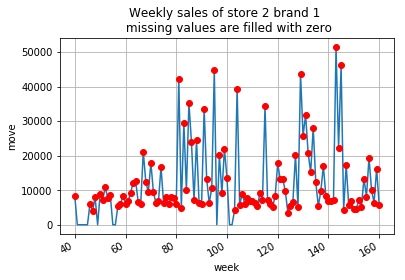

In [7]:
# Plot sample time series of sales
sample_store = 2
sample_brand = 1
sales_sub = sales.loc[(sales['store'] == sample_store) & (sales['brand'] == sample_brand)]
plt.plot(sales_sub['week'], sales_sub['move'])
plt.plot(sales_sub['week'].loc[sales_sub['move'] > 0], 
         sales_sub['move'].loc[sales_sub['move'] > 0], linestyle='', marker='o', color='red')
plt.gcf().autofmt_xdate()
plt.xlabel('week')
plt.ylabel('move')
plt.title('Weekly sales of store {} brand {} \n missing values are filled with zero'.format(sample_store, sample_brand))
plt.grid(True)
plt.show()

Weekly sales of all brands in store 2.


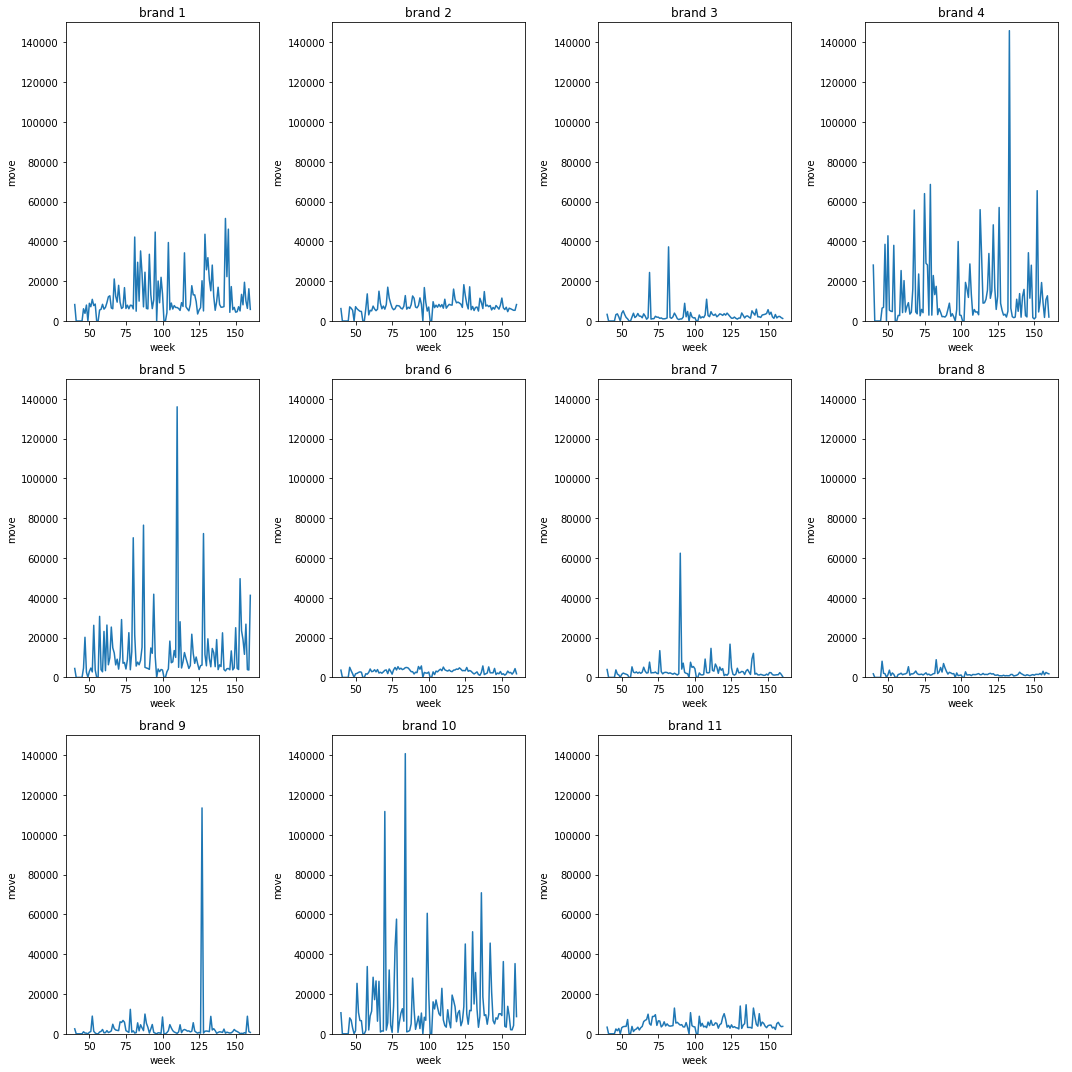

In [8]:
# Plot sales of all brands in a sample store
sample_store = 2
brand_list = sales.loc[(sales['store'] == sample_store), 'brand'].unique()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))
print('Weekly sales of all brands in store {}.'.format(sample_store))

brand_num = 0
for row in axes:
    for col in row:
        if brand_num < len(brand_list):
            brand = brand_list[brand_num]
            sales_sub = sales.loc[(sales['store'] == sample_store) & (sales['brand'] == brand)]
            col.plot(sales_sub['week'], sales_sub['move'])
            col.set_ylim(0, 150000)
            col.set_title('brand {}'.format(brand))
            col.set_xlabel('week')
            col.set_ylabel('move')
            brand_num += 1
        else:
            col.axis('off')
plt.tight_layout()

## Impact of demographics, brand, and store

In this section, we plot the boxplot of the sales across different stores, brands and different values of the demographics variables. There are variations of the sales observed across these variables. We also observed through our modeling experience that once we included the store and brand variables, the contribution of the demographic variables seems to be limited. However, submitters are encouraged to make the decision of whether to include these variables or not according their own judgement.

In [9]:
print('Correlation between unit sales and each demographic feature:')
print(sales[storedemo.columns[1:]].corrwith(sales['move']))
print('\nCorrelation between log-scale sales and each demographic feature:')
print(sales[storedemo.columns[1:]].corrwith(sales['logmove']))

Correlation between unit sales and each demographic feature:
AGE60       0.047409
EDUC       -0.026599
ETHNIC      0.074581
INCOME     -0.050484
HHLARGE     0.000940
WORKWOM    -0.063461
HVAL150    -0.026362
SSTRDIST    0.032859
SSTRVOL    -0.027255
CPDIST5     0.006355
CPWVOL5    -0.078144
dtype: float64

Correlation between log-scale sales and each demographic feature:
AGE60       0.034674
EDUC       -0.012200
ETHNIC      0.044293
INCOME     -0.023183
HHLARGE    -0.026629
WORKWOM    -0.023059
HVAL150    -0.002460
SSTRDIST   -0.006033
SSTRVOL    -0.071799
CPDIST5     0.026050
CPWVOL5    -0.059456
dtype: float64


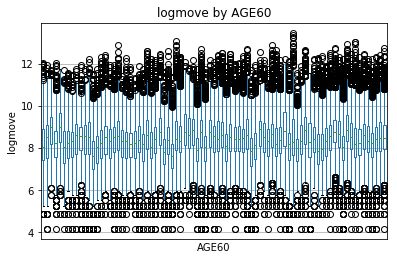

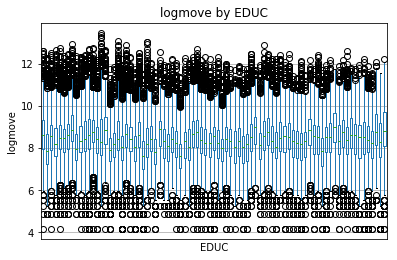

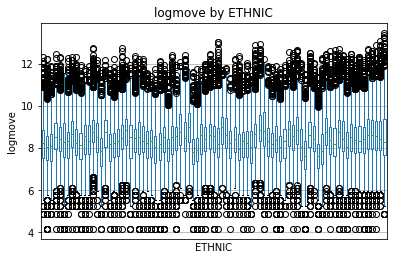

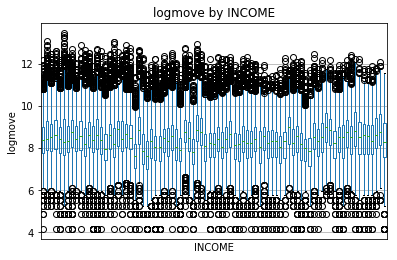

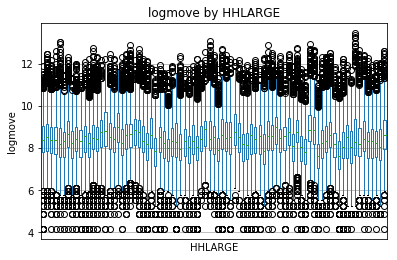

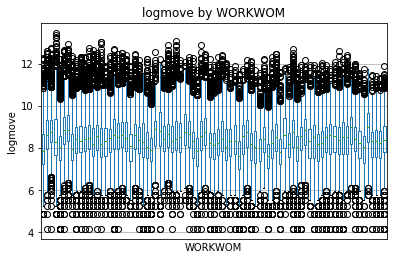

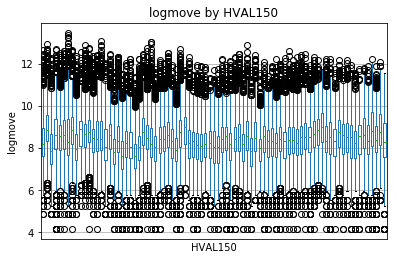

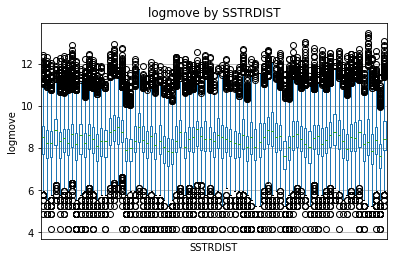

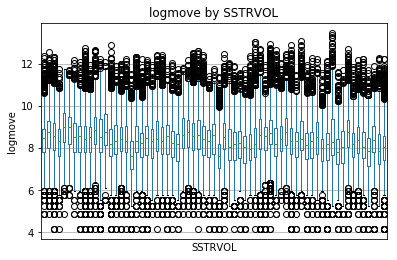

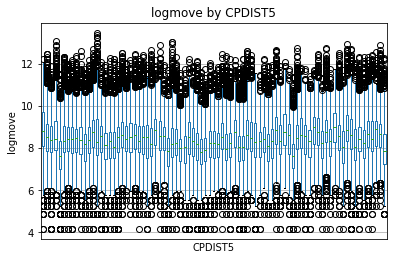

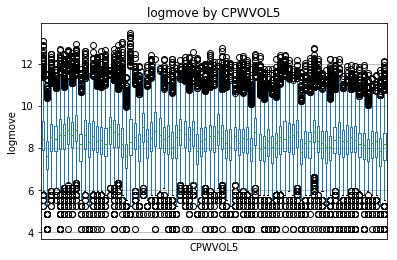

In [10]:
# Plot box plot of logmove vs. store demographic columns
for cl in storedemo.columns[1:]:
    p = sales.loc[sales['logmove'] != 0].boxplot(column='logmove', by=cl)
    p.set_title('logmove by {}'.format(cl), linespacing=3)
    p.set_xlabel(cl)
    p.set_ylabel('logmove')
    p.get_xaxis().set_ticks([])
    plt.suptitle('')

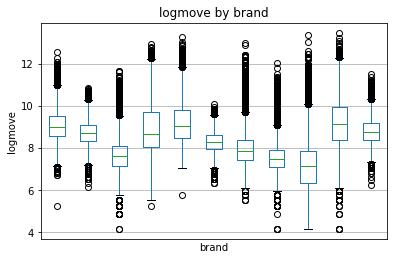

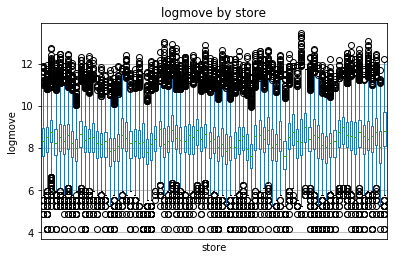

In [11]:
# Plot box plot of logmove across different brands and stores
for by_cl in ['brand', 'store']:
    p = sales.loc[sales['logmove'] != 0].boxplot(column='logmove', by=by_cl)
    p.set_title('logmove by {}'.format(by_cl), linespacing=3)
    p.set_xlabel(by_cl)
    p.set_ylabel('logmove')
    p.get_xaxis().set_ticks([])
    plt.suptitle('')

## Check seasonality and autocorrelation

Overall, we don't find a strong seasonality in the data. It seems that there is a weak yearly-seasonality according to the seasonal-trend-level decomposition and the autocorrelation values around the lag of 52 weeks. As a rough estimate, autocorrelation beyond 20 weeks is usually very small. 

Figure(432x288)


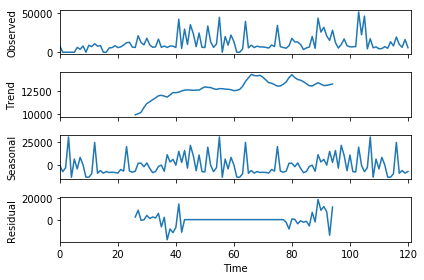

In [12]:
# Check Seasonality 
# Not much seasonality is found
d = sales.loc[(sales['store'] == 2) & (sales['brand'] == 1)].copy()
decom = sm.tsa.seasonal_decompose(d['move'].values, freq=52)
print(decom.plot())

In [13]:
# autocorrealtion: weekly, monthly, quarterly, yearly
def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

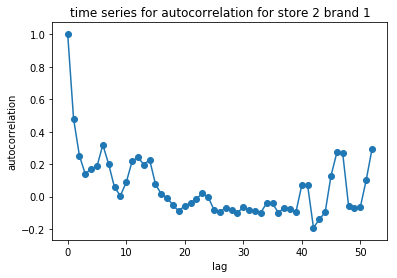

C:\Users\yiychen\AppData\Local\Continuum\Anaconda3\envs\tsperf\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\yiychen\AppData\Local\Continuum\Anaconda3\envs\tsperf\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


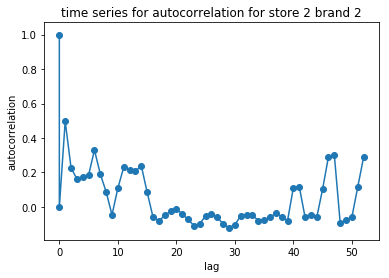

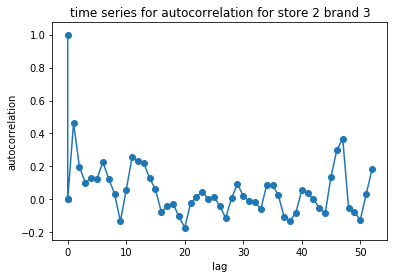

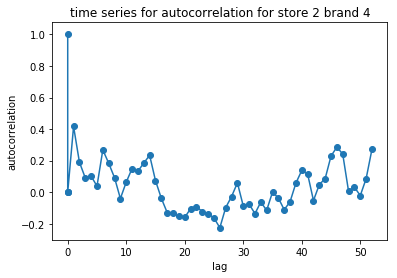

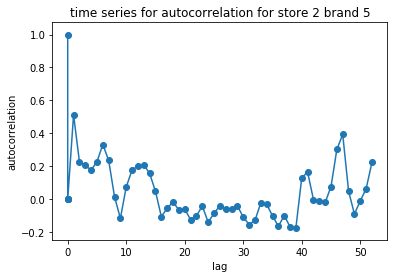

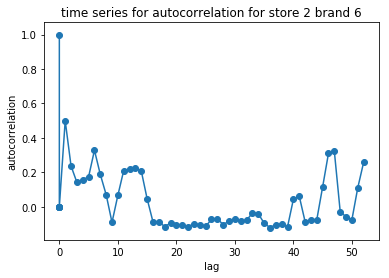

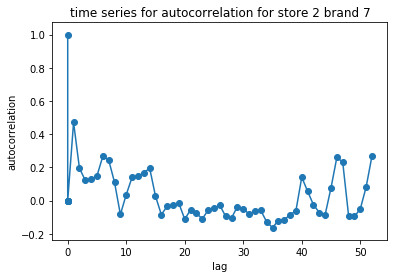

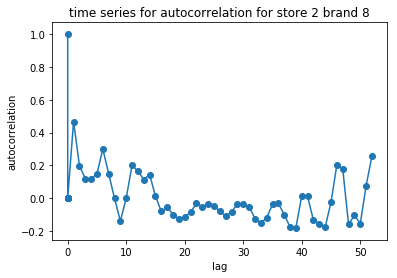

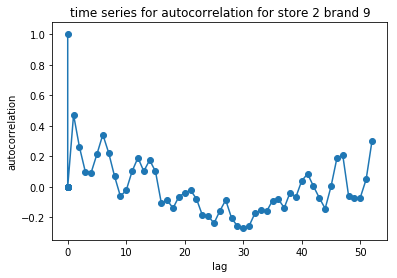

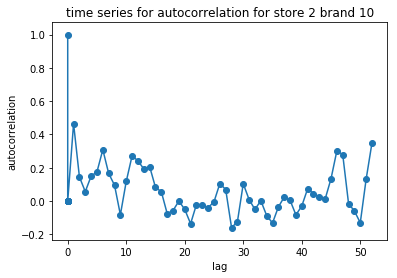

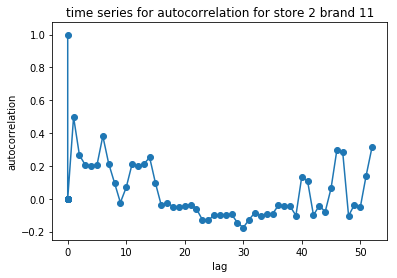

In [14]:
sample_store = 2
brand_list = sales['brand'].unique()
l_range = list(range(1, 53))

for j in range(len(brand_list)):
    brand = brand_list[j]
    d = sales.loc[(sales['store'] == sample_store) & (sales['brand'] == brand)].copy()
    cor = []
    for l in l_range:
        cor.append(single_autocorr(d['logmove'].values, l))
    l_range.insert(0, 0)
    cor.insert(0, 1)
    plt.scatter(list(l_range), cor)
    plt.plot(list(l_range), cor)
    plt.title('time series for autocorrelation for store {} brand {}'.format(sample_store, brand))
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    plt.show()

## Impact of promotional information: deal and feat

We find that deal column has a very significant impact on sales. The impact of feat column also looks strong although the pattern shown in the scatter plot is a bit noisy.

Text(0, 0.5, 'logmove')

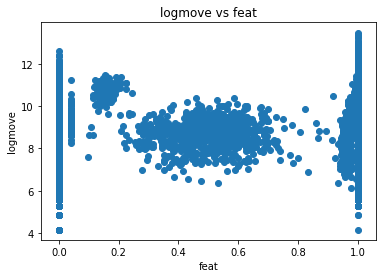

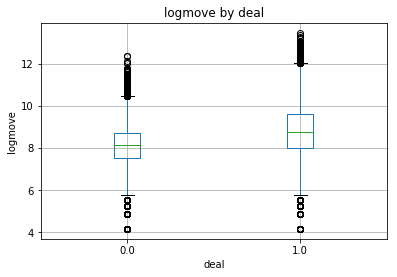

In [15]:
# Check the impact of deal, feat by plotting logmove vs feat and deal
# These two features significantly impact the sales
plt.scatter(sales['feat'], sales['logmove'])
plt.title('logmove vs feat')
plt.xlabel('feat')
plt.ylabel('logmove')
p = sales.boxplot(column='logmove', by='deal')
plt.suptitle('')
p.set_title('logmove by deal', linespacing=3)
p.set_xlabel('deal')
p.set_ylabel('logmove')

## Impact of price

We find that the sales does typically decrease when the absolute price or the relative price of the product increases.

In [16]:
# correlation between the sales and price, sales and relative price
sales['price'] = sales.apply(lambda x: x.loc['price' + str(int(x.loc['brand']))], axis=1)
price_cols = ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 
                 'price9', 'price10', 'price11']
sales['avg_price'] = sales[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
sales['price_ratio'] = sales.apply(lambda x: x['price'] / x['avg_price'], axis=1)

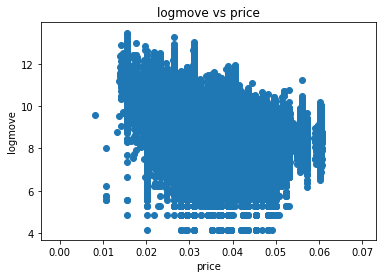

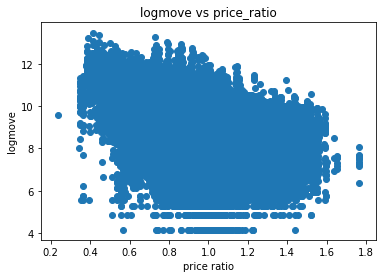

In [17]:
plt.scatter(sales['price'], sales['logmove'])
plt.title('logmove vs price')
plt.xlabel('price')
plt.ylabel('logmove')
plt.show()
plt.scatter(sales['price_ratio'], sales['logmove'])
plt.title('logmove vs price_ratio')
plt.xlabel('price ratio')
plt.ylabel('logmove')
plt.show()

## Impact of holidays 

It seems that the holidays don't have a significant and consistent impact on the sales of orange juices.

In [18]:
# read in the holiday information
week_decoder = pd.read_csv('week_decoder.csv', index_col=False)
sales = sales.merge(week_decoder, how='left', left_on='week', right_on='Week #')
sales['Start'] = pd.to_datetime(sales['Start'])
sales['End'] = pd.to_datetime(sales['End'])
sales['Special Events'] = sales['Special Events'].map(lambda x: x.strip())

logmove           count      mean       std  min       25%       50%  \
Special Events                                                         
4th of July      2739.0  7.483900  2.708179  0.0  7.272398  8.166216   
Christmas        1826.0  8.389864  1.492928  0.0  7.685244  8.515592   
Easter           1826.0  8.414611  1.824091  0.0  7.560080  8.462948   
Halloween        1826.0  8.146464  1.465622  0.0  7.685244  8.166216   
Labor Day        2739.0  7.883681  2.250098  0.0  7.655391  8.317766   
Memorial Day     1826.0  8.049624  2.094664  0.0  7.560080  8.363576   
New-Year         1826.0  8.182360  2.069277  0.0  7.491088  8.499431   
Non-holiday     92213.0  8.094138  1.965484  0.0  7.608871  8.348538   
Presidents Day   1826.0  8.014657  2.123442  0.0  7.377759  8.184235   
Thanksgiving     1826.0  8.275527  1.373684  0.0  7.742402  8.435549   

logmove              75%        max  
Special Events                       
4th of July     8.868413  11.859178  
Christmas       9.281

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

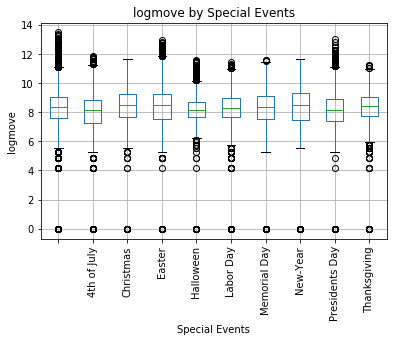

In [19]:
# the logmove statistics for all holidays
sales_copy = sales.copy()
sales_copy.loc[sales_copy['Special Events'] == '', 'Special Events'] = 'Non-holiday'
print(sales_copy.groupby(by='Special Events').apply(lambda x: x['logmove'].describe()))

# box plot for logmove across all holidays
p = sales.boxplot(column='logmove', by='Special Events')
plt.suptitle('')
p.set_title('logmove by Special Events', linespacing=3)
p.set_ylabel('logmove')
plt.xticks(rotation=90)

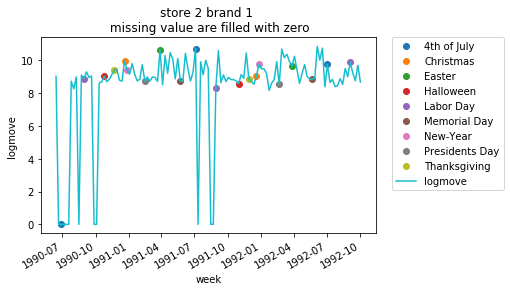

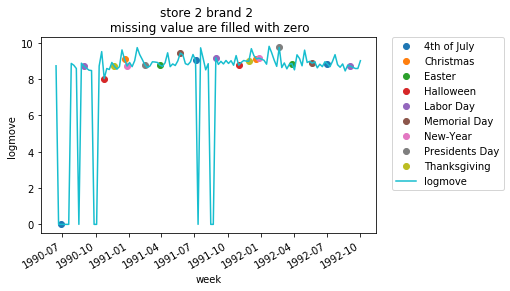

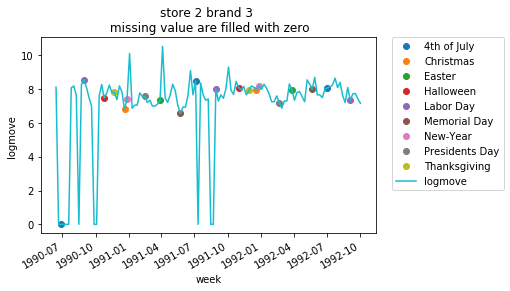

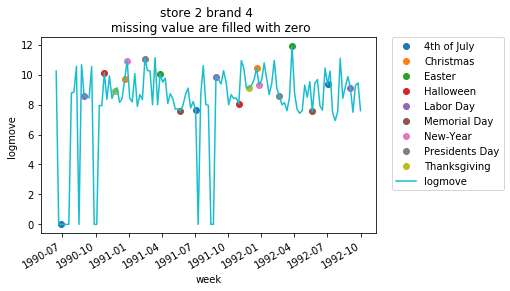

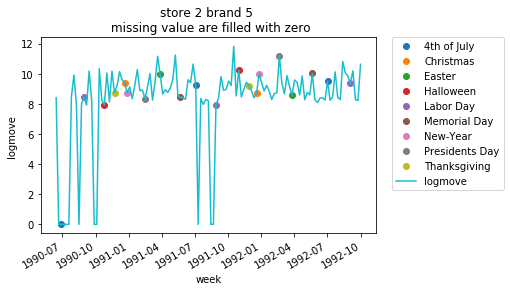

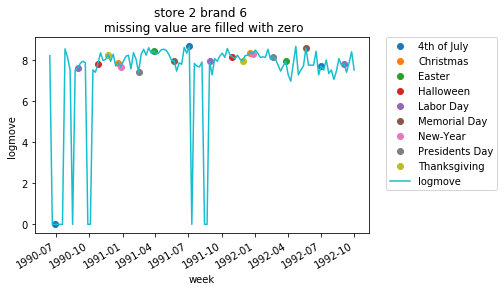

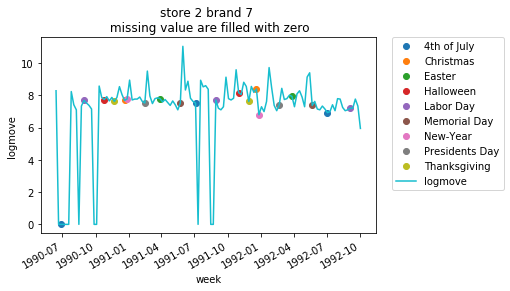

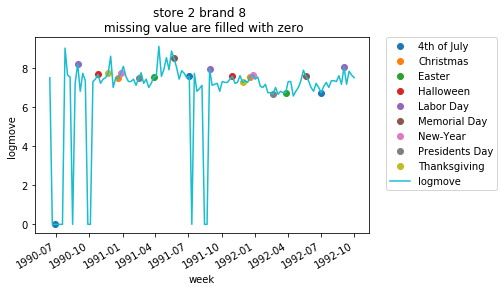

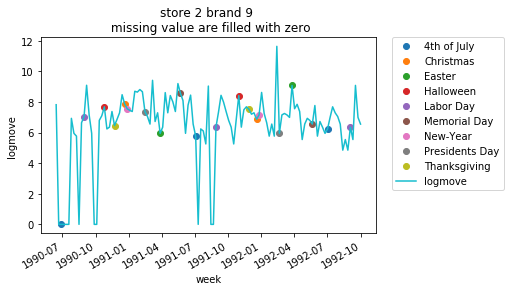

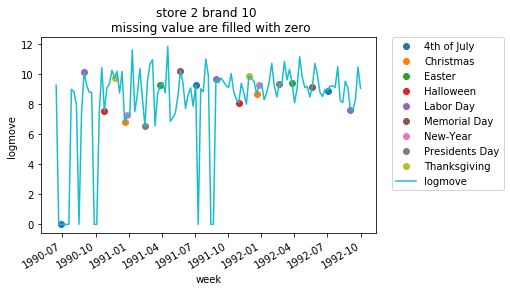

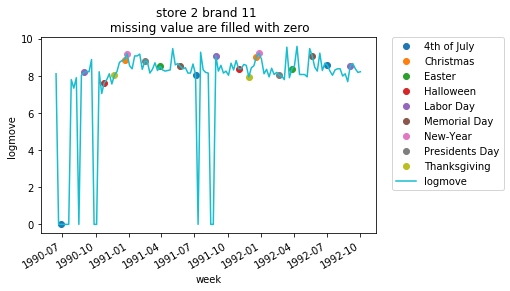

In [20]:
# plot the time series with holiday information marked
max_store_limit = 1
store_list = sales['store'].unique()
brand_list = sales['brand'].unique()
l_range = range(1, 53)

for i in range(min(max_store_limit, len(store_list))):
    for j in range(len(brand_list)):
        store = store_list[i]
        brand = brand_list[j]
        d = sales.loc[(sales['store'] == store) & (sales['brand'] == brand)]
        d_holiday = d.loc[d['Special Events'] != '']
        groups = d_holiday.groupby('Special Events')

        # Plot
        for name, group in groups:
            plt.plot(group['Start'], group['logmove'], 'o', label=name)
        plt.plot(d['Start'], d['logmove'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.gcf().autofmt_xdate()
        plt.title('store {} brand {} \n missing value are filled with zero'.format(store, brand))
        plt.xlabel('week')
        plt.ylabel('logmove')
        plt.show()